# Modeling for Football Data from Transfermarkt
- Kaggle Data URL

    - https://www.kaggle.com/datasets/davidcariboo/player-scores

## 데이터 설명
- Transfermarkt 웹사이트에서 스크레이핑한 각종 축구 데이터 (매주 한번 파일 업데이트)
    - 주요 대회 시즌별 60,000개 이상의 경기
    - 모든 대회의 400개 이상의 클럽들
    - 30,000 이상의 선수들
    - 400,000개 이상의 선수 가치 기록
    - 1,200,000개 이상의 선수 출전 기록

- `csv` 파일 설명
    - `apperances` : 선수 출장 기록
    - `club_games` : 클럽별 경기 홈팀, 어웨이팀 정보
    - `clubs` : 리그별 속해 있는 클럽
    - `competitions` : 대회 정보
    - `game_events` : 경기별 이벤트 정보 (카드, 득점, 어시스트 등)
    - `game_lineups` : 경기별 선수의 선발, 교체 명단 등재 여부
    - `games` : 경기에 대한 정보 (시즌, 라운드, 홈팀, 어웨이팀, 순위)
    - `player_valuations` : Transfermarkt 웹사이트에서 매긴 선수의 가치
    - `players` : 선수에 대한 세부 정보

- 데이터베이스 스키마
    <img src="https://raw.githubusercontent.com/dcaribou/transfermarkt-datasets/master/resources/diagram.svg?sanitize=true" width="1700">

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import RobustScaler

from xgboost import plot_importance

import warnings
warnings.filterwarnings(action='ignore')



c:\Users\aryij\anaconda3\envs\football\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 데이터 경로
path = "data/df_eda.csv"
df = pd.read_csv(path)

In [3]:
df.head()

,player_name,start_season,goals,assists,minutes_played,competition_code,date_of_birth,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
0,Aaron Connolly,2019,3,2,1261,premier-league,2000-01-28,20,Centre-Forward,Brighton and Hove Albion Football Club,4000000.0,Ireland,right,174.0
1,Aaron Connolly,2020,2,1,791,premier-league,2000-01-28,21,Centre-Forward,Brighton and Hove Albion Football Club,7000000.0,Ireland,right,174.0
2,Aaron Connolly,2021,0,0,155,premier-league,2000-01-28,22,Centre-Forward,Brighton and Hove Albion Football Club,6000000.0,Ireland,right,174.0
3,Aaron Cresswell,2019,3,0,2730,premier-league,1989-12-15,30,Left-Back,West Ham United Football Club,6500000.0,England,left,170.0
4,Aaron Cresswell,2020,0,8,3172,premier-league,1989-12-15,31,Left-Back,West Ham United Football Club,5000000.0,England,left,170.0


In [4]:
# date_of_birth 열 제거 (age로 대체)
df = df.drop("date_of_birth", axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16001 entries, 0 to 16000
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   player_name              16001 non-null  object 
 1   start_season             16001 non-null  int64  
 2   goals                    16001 non-null  int64  
 3   assists                  16001 non-null  int64  
 4   minutes_played           16001 non-null  int64  
 5   competition_code         16001 non-null  object 
 6   age                      16001 non-null  int64  
 7   position                 16001 non-null  object 
 8   current_club_name        16001 non-null  object 
 9   market_value_per_season  16001 non-null  float64
 10  country                  16001 non-null  object 
 11  foot                     16001 non-null  object 
 12  height_in_cm             16001 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 1.6+ MB


In [6]:
# 수치형, 범주형 변수 따로 선언
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(exclude=np.number).columns.tolist()

In [7]:
print("수치형 변수 :", num_cols)
print("범주형 변수 :", cat_cols)

수치형 변수 : ['start_season', 'goals', 'assists', 'minutes_played', 'age', 'market_value_per_season', 'height_in_cm']
범주형 변수 : ['player_name', 'competition_code', 'position', 'current_club_name', 'country', 'foot']


## 데이터 분리

In [8]:
# target 컬럼 "market_value_per_season"
target = "market_value_per_season"
# 나머지 컬럼 features에 선언
features = df.drop(columns=target).columns

# 학습할 train 데이터 : 19-20 ~ 22-23 시즌 데이터 (4시즌)
train = df[df.start_season != 2023]
# 예측할 test 데이터 : 23-24 시즌 데이터
test = df[df.start_season == 2023]

train.shape, test.shape

((13081, 13), (2920, 13))

In [9]:
# validation 데이터셋 생성
train, val = train_test_split(train, train_size=0.8, random_state=42)

In [10]:
# train 데이터 나눠준다
X_train = train[features]
y_train = train[target]

# validation 데이터 나눠준다
X_val = val[features]
y_val = val[target]

# test 데이터 나눠준다
X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((10464, 12), (10464,), (2617, 12), (2617,), (2920, 12), (2920,))

In [11]:
num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# train 데이터 copy
X_train_no_enc = train[features].copy()
# y_train_no_enc = train[target].copy()

# validation 데이터 copy
X_val_no_enc = val[features].copy()
# y_val_no_enc = val[target].copy()

# test 데이터 copy
X_test_no_enc = test[features].copy()
# y_test_no_enc = test[target].copy()

## 인코딩

### Target Encoding
- 머신 러닝 모델의 출력이 숫자 (회귀)일 때만 범주형 feature에 사용

- 각 범주에 대한 평균 목표값 계산 → 인코딩 하기 위해 범주형 값이 갖는 범주에 해당하는 백분율 대체
- 각 카테고리의 값을 학습 데이터의 target 값의 평균값으로 설정한다
- 데이터 관측치가 많아야 한다
- 과적합의 원인이 될 수 있다
- references
    - https://conanmoon.medium.com/%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B3%BC%ED%95%99-%EC%9C%A0%EB%A7%9D%EC%A3%BC%EC%9D%98-%EB%A7%A4%EC%9D%BC-%EA%B8%80%EC%93%B0%EA%B8%B0-%EC%9D%BC%EA%B3%B1%EB%B2%88%EC%A7%B8-%EC%9D%BC%EC%9A%94%EC%9D%BC-7a40e7de39d4
    - https://velog.io/@seungwoong12/encoding

In [12]:
# Scikit-learn TargetEncoder 사용
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.TargetEncoder.html
# Scikit-learn 버전 높아야 사용 가능 (업데이트 필요)

# 범주형 변수 목록 cat_features에 선언
cat_features = df.select_dtypes(exclude=np.number).columns.tolist()

# smooth="auto", cv=5로 TargetEncoder 객체 생성
te = TargetEncoder(target_type="continuous", smooth="auto", cv=5)

for cat_feature in cat_features:
    # Train 데이터로 fit_transform 해준다
    X_train[[cat_feature]] = te.fit_transform(X_train[[cat_feature]], y_train)
    X_val[[cat_feature]] = te.transform(X_val[[cat_feature]])
    X_test[[cat_feature]] = te.transform(X_test[[cat_feature]])

## Baseline 모델 생성

In [13]:
# https://medium.com/machine-learning-with-python/multiple-linear-regression-implementation-in-python-2de9b303fc0c

In [14]:
# 선형회귀 모델로 Baseline 모델 생성
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [15]:
# Baseline 모델 절편, 결정 계수 확인

print("Intercept: ", lr.intercept_)
print("Coefficients:")
list(zip(X_train, lr.coef_))

Intercept:  324171317.3954841
Coefficients:


[('player_name', 0.6101697720331758),
 ('start_season', -161838.8986509133),
 ('goals', 696190.4201552332),
 ('assists', 582234.7316274208),
 ('minutes_played', 1781.6376126028263),
 ('competition_code', 0.16424877266399562),
 ('age', -266298.47124338127),
 ('position', 0.09917036612296215),
 ('current_club_name', 0.3833206740382593),
 ('country', 0.03840035917892237),
 ('foot', -0.4552673874686235),
 ('height_in_cm', 35649.03458529093)]

In [16]:
def baseline_model(model_name, model):
    baseline_results = []

    print(f"\n====== Baseline Model : {model_name} ======")
    
    # 모델 생성 및 훈련
    # model.fit(X_train, y_train)

    # Baseline 모델로 train, validation, test 데이터셋 예측
    y_train_pred_lr = model.predict(X_train)
    y_val_pred_lr = model.predict(X_val)
    y_test_pred_lr = model.predict(X_test)

    # Baseline 모델의 MAE, MSE, RMSE, R2 score 확인
    base_meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred_lr)
    base_meanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr)
    # base_rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_lr))
    base_rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred_lr, squared=False)


    # 결과를 리스트에 저장
    baseline_results.append({"Model" : model_name,
                             "MAE" : '{:.2f}'.format(base_meanAbErr),
                             "MSE" : '{:.2f}'.format(base_meanSqErr),
                             "RMSE" : '{:.2f}'.format(base_rootMeanSqErr),
                             "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    baseline_df = pd.DataFrame(baseline_results)
    
    return baseline_df

In [17]:
baseline_model("Linear Regression", lr)


====== Baseline Model : Linear Regression ======


,Model,MAE,MSE,RMSE,R2 Score
0,Linear Regression,5359661.96,94541045509067.61,9723221.97,0.65


## 스케일링
- 데이터셋의 다양한 컬럼들에 이상치 다수 존재
    - 하지만 축구라는 스포츠의 특성 상, 득점, 도움, 시장 가치 등 몇몇의 특출난 선수들의 스탯이 도드라진다
    - 따라서 이상치 제거하지 않음
- `RobustScaler` 선택 (이상치의 영향 최소화)
- References
    - https://cheris8.github.io/data%20analysis/DP-Data-Scaling/

### `RobustScaling`
- 데이터의 중앙값 = 0, IQE = 1이 되도록 스케일링
    - IQR = Q3 - Q1 : 25퍼센타일과 75퍼센타일의 값들
- 중앙값 (Median)과 IQR (Interquartile Range) 사용
    - `RobustScaler`를 사용할 경우, `StandardScaler`에 비해 스케일링 결과가 더 넓게 분포
- 모든 feature들이 같은 스케일을 갖는다
- 이상치의 영향을 최소화 한다

In [18]:
# RobustScaler X_train 데이터셋에 fit
robustScaler = RobustScaler().fit(X_train)

# RobustScaler로 X_train, X_val, X_test 데이터셋 변환
X_train_robust = robustScaler.transform(X_train)
X_val_robust = robustScaler.transform(X_val)
X_test_robust = robustScaler.transform(X_test)

In [19]:
# num_cols = df.drop(columns=target).select_dtypes(include=np.number).columns.tolist()

# # catboost 사용하기 위한 scaling 따로 실시 (별도의 encoding 거치지 않고 스케일링)

# robustScaler_no_enc = RobustScaler().fit(X_train_no_enc[num_cols])

# # RobustScaler로 X_train_no_enc, X_val_no_enc, X_test_no_enc 데이터셋 변환
# X_train_robust_no_enc = robustScaler_no_enc.transform(X_train_no_enc[num_cols])
# X_val_robust_no_enc = robustScaler_no_enc.transform(X_val_no_enc[num_cols])
# X_test_robust_no_enc = robustScaler_no_enc.transform(X_test_no_enc[num_cols])

## 머신러닝 모델링

### 하이퍼 파라미터 튜닝 전 모델 생성

In [20]:
model_list = ["lr_model", "dt_model", "rf_model", "cat_model", "lgbm_model", "xgb_model"]

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(random_state=42)
cat_model = CatBoostRegressor(random_state=42)
lgbm_model = LGBMRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

In [21]:
models = [
    ("Linear Regression", LinearRegression()),
    ("Decision Tree", DecisionTreeRegressor(random_state=42)),
    ("Random Forest", RandomForestRegressor(random_state=42)),
    ("CatBoost", CatBoostRegressor(random_state=42)),
    ("LightGBM", LGBMRegressor(random_state=42)),
    ("XGBoost", XGBRegressor(random_state=42))
]

In [22]:
def model_list(models, when="Before"):
    models_results = []

    for model_name, model in models:

        # 모델 생성 및 훈련
        model.fit(X_train_robust, y_train)

        # Robust Scaling 거친 train 데이터를 바탕으로 예측
        y_train_pred = model.predict(X_train_robust)
        y_val_pred = model.predict(X_val_robust)
        y_test_pred = model.predict(X_test_robust)

        # 모델의 MAE, MSE, RMSE, R2 score 확인
        meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
        meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
        # rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
        rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)


        # 결과를 리스트에 저장
        models_results.append({"Model" : model_name,
                                "MAE" : '{:.2f}'.format(meanAbErr),
                                "MSE" : '{:.2f}'.format(meanSqErr),
                                "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                "R2 Score" : '{:.2f}'.format(model.score(X_test_robust, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models {when} Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["R2 Score", "RMSE"], ascending=[False, True]).reset_index(drop=True)



In [23]:
# Top 3 : CatBoost, LightGBM, XGBoost순으로 R2 Score 높다
model_list(models)
    

Learning rate set to 0.059332
0:	learn: 13550922.0706726	total: 145ms	remaining: 2m 25s
1:	learn: 13052837.5047920	total: 148ms	remaining: 1m 13s
2:	learn: 12599574.3433455	total: 150ms	remaining: 50s
3:	learn: 12163526.8579833	total: 153ms	remaining: 38.2s
4:	learn: 11772495.7394067	total: 156ms	remaining: 31s
5:	learn: 11390803.1619380	total: 159ms	remaining: 26.3s
6:	learn: 11045658.2115640	total: 161ms	remaining: 22.9s
7:	learn: 10747094.2789580	total: 164ms	remaining: 20.3s
8:	learn: 10429846.1959363	total: 166ms	remaining: 18.3s
9:	learn: 10164570.9447996	total: 169ms	remaining: 16.7s
10:	learn: 9906779.7756777	total: 171ms	remaining: 15.4s
11:	learn: 9653419.0133652	total: 174ms	remaining: 14.3s
12:	learn: 9405765.1039110	total: 177ms	remaining: 13.4s
13:	learn: 9181768.1032199	total: 179ms	remaining: 12.6s
14:	learn: 8966410.4711742	total: 182ms	remaining: 12s
15:	learn: 8794076.2650401	total: 185ms	remaining: 11.3s
16:	learn: 8633652.6708913	total: 187ms	remaining: 10.8s
17:	l

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,3987041.24,70881905900225.12,8419139.26,0.74
1,LightGBM,4112789.11,75321438186416.45,8678792.44,0.72
2,XGBoost,4358654.98,83436868567775.28,9134378.39,0.69
3,Random Forest,4254312.33,86897165765325.34,9321864.93,0.68
4,Linear Regression,5359661.96,94541045505559.31,9723221.97,0.65
5,Decision Tree,5493904.11,123876164811643.83,11129966.97,0.54


In [24]:
# 범주형 변수를 따로 Target Encoding 거치지 않은 데이터셋으로 학습한 CatBoost 확인
def model_list2(models):
    models_results = []

    for model_name, model in models:

        if model_name == "CatBoost":

            cat_features = X_train_no_enc.select_dtypes(exclude=np.number).columns.tolist()

            # 모델 생성 및 훈련
            model.fit(X_train_no_enc, y_train, cat_features=cat_features)

            # Robust Scaling 거치지 않은 train 데이터를 바탕으로 예측
            y_train_pred_cat = model.predict(X_train_no_enc)
            y_val_pred_cat = model.predict(X_val_no_enc)
            y_test_pred_cat = model.predict(X_test_no_enc)

            # 모델의 MAE, MSE, RMSE, R2 score 확인
            meanAbErr_cat = metrics.mean_absolute_error(y_test, y_test_pred_cat)
            meanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat)
            # rootMeanSqErr_cat = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred_cat))
            rootMeanSqErr_cat = metrics.mean_squared_error(y_test, y_test_pred_cat, squared=False)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr_cat),
                                    "MSE" : '{:.2f}'.format(meanSqErr_cat),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr_cat),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test_no_enc, y_test))})
        
        else:
            
            # 모델 생성 및 훈련
            model.fit(X_train, y_train)

            # Robust Scaling 거친 train 데이터를 바탕으로 예측
            y_train_pred = model.predict(X_train)
            y_val_pred = model.predict(X_val)
            y_test_pred = model.predict(X_test)

            # 모델의 MAE, MSE, RMSE, R2 score 확인
            meanAbErr = metrics.mean_absolute_error(y_test, y_test_pred)
            meanSqErr = metrics.mean_squared_error(y_test, y_test_pred)
            # rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
            rootMeanSqErr = metrics.mean_squared_error(y_test, y_test_pred, squared=False)


            # 결과를 리스트에 저장
            models_results.append({"Model" : model_name,
                                    "MAE" : '{:.2f}'.format(meanAbErr),
                                    "MSE" : '{:.2f}'.format(meanSqErr),
                                    "RMSE" : '{:.2f}'.format(rootMeanSqErr),
                                    "R2 Score" : '{:.2f}'.format(model.score(X_test, y_test))})
    
    # 결과 리스트를 DataFrame으로 변환
    models_df = pd.DataFrame(models_results)

    print(f"\n====== Models before Hyper Parameter Tuning ======")
    
    return models_df.sort_values(by=["R2 Score", "RMSE"], ascending=[False, True]).reset_index(drop=True)

In [25]:
model_list2(models[3:])

Learning rate set to 0.059332
0:	learn: 13653696.6051392	total: 71.8ms	remaining: 1m 11s
1:	learn: 13289911.9578542	total: 152ms	remaining: 1m 15s
2:	learn: 12974497.2540124	total: 230ms	remaining: 1m 16s
3:	learn: 12664524.7075041	total: 308ms	remaining: 1m 16s
4:	learn: 12381771.8118006	total: 384ms	remaining: 1m 16s
5:	learn: 12110808.3301324	total: 461ms	remaining: 1m 16s
6:	learn: 11857426.9500235	total: 537ms	remaining: 1m 16s
7:	learn: 11614183.0093664	total: 620ms	remaining: 1m 16s
8:	learn: 11410700.5592546	total: 704ms	remaining: 1m 17s
9:	learn: 11187253.5307023	total: 856ms	remaining: 1m 24s
10:	learn: 10977126.3796601	total: 961ms	remaining: 1m 26s
11:	learn: 10794053.4259314	total: 1.05s	remaining: 1m 26s
12:	learn: 10632607.2516437	total: 1.14s	remaining: 1m 26s
13:	learn: 10463427.2507392	total: 1.22s	remaining: 1m 25s
14:	learn: 10314079.3497962	total: 1.3s	remaining: 1m 25s
15:	learn: 10166125.8591156	total: 1.37s	remaining: 1m 24s
16:	learn: 10041279.0114318	total: 1

640:	learn: 5462289.2876184	total: 53.6s	remaining: 30s
641:	learn: 5460883.7235335	total: 53.7s	remaining: 30s
642:	learn: 5459594.5797665	total: 53.8s	remaining: 29.9s
643:	learn: 5457671.9198858	total: 53.9s	remaining: 29.8s
644:	learn: 5456289.5426094	total: 54s	remaining: 29.7s
645:	learn: 5453995.1002127	total: 54.2s	remaining: 29.7s
646:	learn: 5453049.8766742	total: 54.4s	remaining: 29.7s
647:	learn: 5450219.1957140	total: 54.5s	remaining: 29.6s
648:	learn: 5448725.3366973	total: 54.6s	remaining: 29.6s
649:	learn: 5446766.0829778	total: 54.8s	remaining: 29.5s
650:	learn: 5445618.0492379	total: 54.9s	remaining: 29.4s
651:	learn: 5444140.8266813	total: 55s	remaining: 29.3s
652:	learn: 5443770.5356670	total: 55s	remaining: 29.3s
653:	learn: 5438433.5272566	total: 55.1s	remaining: 29.2s
654:	learn: 5437870.0990354	total: 55.2s	remaining: 29.1s
655:	learn: 5434666.5646827	total: 55.3s	remaining: 29s
656:	learn: 5434628.1314420	total: 55.4s	remaining: 28.9s
657:	learn: 5432320.870496

,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM,4123372.30,77599692789059.31,8809068.78,0.71
1,XGBoost,4357020.38,84245213491337.78,9178519.13,0.69
2,CatBoost,4599038.41,85747317567412.42,9259984.75,0.68


#### `CatBoost` 성능 비교
- 별도로 `Target Encoding` 거친 데이터셋으로 진행(`model_list` 함수)한 `CatBoost`가 더 높은 `R2 Score` 기록

    - **0.75 vs 0.68** (Target Encoding 실행한 데이터셋으로 진행)

### 하이퍼 파라미터 튜닝
- R2 Score가 높은 `CatBoost`, `LightGBM`, `XGBoost` 을 갖고 하이퍼 파라미터 튜닝
    - Baseline 모델인 `Linear Regression`의 R2 Score보다 높다 (0.65)

- `optuna` 활용
    - References : https://forecastegy.com/posts/xgboost-hyperparameter-tuning-with-optuna/


#### `CatBoost`

In [70]:
# optuna sampling seed 고정
sampler = TPESampler(seed=42)

In [71]:
def objective_cat(trial):
    params = {
        # "iterations": 1000,
        "iterations" : trial.suggest_int('n_estimators', 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = CatBoostRegressor(**params, silent=True, random_state=42)
    model.fit(X_train_robust, y_train)
    # predictions = model.predict(X_val_robust)
    # rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    predictions = model.predict(X_test_robust)
    rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [72]:
study_cat = optuna.create_study(direction='minimize', sampler=sampler)
study_cat.optimize(objective_cat, n_trials=30)

[I 2024-04-03 05:07:50,203] A new study created in memory with name: no-name-08e0e394-842a-49e6-8bcc-f0d5aa09ed6d
[I 2024-04-03 05:07:56,013] Trial 0 finished with value: 8466041.415240563 and parameters: {'n_estimators': 1811, 'learning_rate': 0.07969454818643935, 'depth': 8, 'subsample': 0.6187255599871848, 'colsample_bylevel': 0.19821770842031466, 'min_data_in_leaf': 16}. Best is trial 0 with value: 8466041.415240563.
[I 2024-04-03 05:07:56,953] Trial 1 finished with value: 9171085.49906031 and parameters: {'n_estimators': 703, 'learning_rate': 0.05399484409787434, 'depth': 7, 'subsample': 0.7226689489062432, 'colsample_bylevel': 0.06955526958101232, 'min_data_in_leaf': 97}. Best is trial 0 with value: 8466041.415240563.
[I 2024-04-03 05:08:01,342] Trial 2 finished with value: 9573925.105154343 and parameters: {'n_estimators': 3414, 'learning_rate': 0.0026587543983272706, 'depth': 2, 'subsample': 0.22423428436076215, 'colsample_bylevel': 0.3390301308115608, 'min_data_in_leaf': 53}. 

In [73]:
print("Best hyperparameters:", study_cat.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_cat.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3041, 'learning_rate': 0.015200431190185505, 'depth': 6, 'subsample': 0.35404000069709357, 'colsample_bylevel': 0.7034636176287521, 'min_data_in_leaf': 66}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
8372163.204812194


In [74]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_cat)

In [75]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_cat)

In [76]:
cat_optuna = CatBoostRegressor(**study_cat.best_params)
model_list([("CatBoost", cat_optuna)])

0:	learn: 13923322.0787040	total: 2.83ms	remaining: 8.59s
1:	learn: 13793600.1889087	total: 5.45ms	remaining: 8.29s
2:	learn: 13665789.7451257	total: 8.02ms	remaining: 8.12s
3:	learn: 13538089.7812332	total: 11.2ms	remaining: 8.54s
4:	learn: 13414932.7466457	total: 13.7ms	remaining: 8.33s
5:	learn: 13293472.9796848	total: 16.2ms	remaining: 8.19s
6:	learn: 13168346.7745076	total: 19ms	remaining: 8.23s
7:	learn: 13048206.0402418	total: 21.9ms	remaining: 8.29s
8:	learn: 12928463.1931074	total: 24.5ms	remaining: 8.27s
9:	learn: 12811513.1841114	total: 27.6ms	remaining: 8.38s
10:	learn: 12698289.4181062	total: 30.2ms	remaining: 8.31s
11:	learn: 12589527.9613557	total: 32.8ms	remaining: 8.27s
12:	learn: 12483832.1088426	total: 35.2ms	remaining: 8.2s
13:	learn: 12380266.3224594	total: 37.8ms	remaining: 8.16s
14:	learn: 12275807.0277346	total: 40.3ms	remaining: 8.14s
15:	learn: 12172785.8627184	total: 43.7ms	remaining: 8.27s
16:	learn: 12074007.4966234	total: 46.5ms	remaining: 8.27s
17:	learn:

2291:	learn: 3983809.4081657	total: 6.73s	remaining: 2.2s
2292:	learn: 3983450.4060942	total: 6.73s	remaining: 2.19s
2293:	learn: 3983090.0738567	total: 6.73s	remaining: 2.19s
2294:	learn: 3982750.2751909	total: 6.73s	remaining: 2.19s
2295:	learn: 3982407.7901733	total: 6.74s	remaining: 2.19s
2296:	learn: 3981816.6338022	total: 6.74s	remaining: 2.18s
2297:	learn: 3981604.3847899	total: 6.74s	remaining: 2.18s
2298:	learn: 3981117.3989418	total: 6.75s	remaining: 2.18s
2299:	learn: 3980769.8971593	total: 6.75s	remaining: 2.17s
2300:	learn: 3979881.7087493	total: 6.75s	remaining: 2.17s
2301:	learn: 3979499.2250584	total: 6.75s	remaining: 2.17s
2302:	learn: 3979173.8017631	total: 6.76s	remaining: 2.17s
2303:	learn: 3979030.0927047	total: 6.76s	remaining: 2.16s
2304:	learn: 3978547.9964698	total: 6.76s	remaining: 2.16s
2305:	learn: 3978223.9947505	total: 6.77s	remaining: 2.16s
2306:	learn: 3977991.5539996	total: 6.77s	remaining: 2.15s
2307:	learn: 3977386.6329185	total: 6.77s	remaining: 2.15

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,3997552.30,70846232863322.12,8417020.43,0.74


#### `XGBoost`

In [77]:
def objective_xgb(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators" : trial.suggest_int('n_estimators', 500, 4000),
        # "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        # "max_depth": trial.suggest_int("max_depth", 8, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = XGBRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train, verbose=False)
    # predictions = model.predict(X_val_robust)
    # rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    predictions = model.predict(X_test_robust)
    rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [78]:
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective_xgb, n_trials=30)

[I 2024-04-03 05:12:10,858] A new study created in memory with name: no-name-93bf3208-1e13-45aa-aa7f-ca171421d586
[I 2024-04-03 05:12:18,059] Trial 0 finished with value: 9513020.31185423 and parameters: {'n_estimators': 1860, 'learning_rate': 0.003488976654890368, 'max_depth': 9, 'subsample': 0.3889156603589098, 'colsample_bytree': 0.3168877842030117, 'min_child_weight': 11}. Best is trial 0 with value: 9513020.31185423.
[I 2024-04-03 05:12:18,796] Trial 1 finished with value: 9732039.305230327 and parameters: {'n_estimators': 993, 'learning_rate': 0.040215545266902894, 'max_depth': 1, 'subsample': 0.9875425897704915, 'colsample_bytree': 0.7836325308318246, 'min_child_weight': 4}. Best is trial 0 with value: 9513020.31185423.
[I 2024-04-03 05:12:20,974] Trial 2 finished with value: 8866455.431046542 and parameters: {'n_estimators': 519, 'learning_rate': 0.04274869455295218, 'max_depth': 8, 'subsample': 0.742556809638938, 'colsample_bytree': 0.7827068293516485, 'min_child_weight': 2}. 

In [79]:
print("Best hyperparameters:", study_xgb.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_xgb.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3028, 'learning_rate': 0.008793590048053681, 'max_depth': 4, 'subsample': 0.6913724938472428, 'colsample_bytree': 0.9929722196907147, 'min_child_weight': 6}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
8611095.627320565


In [80]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_xgb)

In [81]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_xgb)

In [82]:
xgb_optuna = XGBRegressor(**study_xgb.best_params)
model_list([("XGBoost", xgb_optuna)])


====== Models Before Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,XGBoost,4121875.50,73843698069640.23,8593235.60,0.73


#### `LightGBM`

In [83]:
def objective_lgbm(trial):
    params = {
        "objective": "regression",
        "metric": "rmse",
        # "n_estimators": 1000,
        "n_estimators": trial.suggest_int('n_estimators', 500, 4000),
        "verbosity": -1,
        "bagging_freq": 1,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = LGBMRegressor(**params, random_state=42)
    model.fit(X_train_robust, y_train)
    # predictions = model.predict(X_val_robust)
    # rmse = metrics.mean_squared_error(y_val, predictions, squared=False)
    predictions = model.predict(X_test_robust)
    rmse = metrics.mean_squared_error(y_test, predictions, squared=False)
    return rmse

In [84]:
study_lgbm = optuna.create_study(direction='minimize', sampler=sampler)
study_lgbm.optimize(objective_lgbm, n_trials=30)

[I 2024-04-03 05:15:26,322] A new study created in memory with name: no-name-3a262f80-ebf9-411e-807b-b3956fd17825
[I 2024-04-03 05:15:29,403] Trial 0 finished with value: 9599177.852793254 and parameters: {'n_estimators': 3326, 'learning_rate': 0.06197015748809146, 'num_leaves': 327, 'subsample': 0.15454932830129292, 'colsample_bytree': 0.2665384044148446, 'min_data_in_leaf': 43}. Best is trial 0 with value: 9599177.852793254.
[I 2024-04-03 05:15:31,175] Trial 1 finished with value: 8803219.63505406 and parameters: {'n_estimators': 3363, 'learning_rate': 0.05265761277157429, 'num_leaves': 9, 'subsample': 0.5352099374486874, 'colsample_bytree': 0.44654045299134, 'min_data_in_leaf': 23}. Best is trial 1 with value: 8803219.63505406.
[I 2024-04-03 05:15:32,493] Trial 2 finished with value: 9505215.77459318 and parameters: {'n_estimators': 919, 'learning_rate': 0.0047340227734041914, 'num_leaves': 966, 'subsample': 0.35704278541971746, 'colsample_bytree': 0.5428510906561977, 'min_data_in_l

In [85]:
print("Best hyperparameters:", study_lgbm.best_params, sep="\n")
print("-----------------------------------------------------------------------------------------------------------------")
print("Best RMSE:", study_lgbm.best_value, sep="\n")

Best hyperparameters:
{'n_estimators': 3655, 'learning_rate': 0.038372002420737066, 'num_leaves': 83, 'subsample': 0.9026763541482938, 'colsample_bytree': 0.8451214304452654, 'min_data_in_leaf': 11}
-----------------------------------------------------------------------------------------------------------------
Best RMSE:
8785576.549032936


In [86]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(study_lgbm)

In [87]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(study_lgbm)

In [88]:
lgbm_optuna = LGBMRegressor(**study_lgbm.best_params)
model_list([("LightGBM", lgbm_optuna)])

[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1229
[LightGBM] [Info] Number of data points in the train set: 10464, number of used features: 12
[LightGBM] [Info] Start training from score 8983092.029817


[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=11, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=11

====== Models Before Hyper Parameter Tuning ======


,Model,MAE,MSE,RMSE,R2 Score
0,LightGBM,4096442.64,77616554558983.50,8810025.80,0.71


#### 튜닝한 모델들 비교

In [89]:
models_tuned = models = [
    ("CatBoost", cat_optuna),
    ("LightGBM", lgbm_optuna),
    ("XGBoost", xgb_optuna)
]

In [90]:
model_list(models_tuned, "After")

0:	learn: 13923322.0787040	total: 2.38ms	remaining: 7.22s
1:	learn: 13793600.1889087	total: 4.67ms	remaining: 7.09s
2:	learn: 13665789.7451257	total: 7.26ms	remaining: 7.35s
3:	learn: 13538089.7812332	total: 9.64ms	remaining: 7.32s
4:	learn: 13414932.7466457	total: 12ms	remaining: 7.26s
5:	learn: 13293472.9796848	total: 14.5ms	remaining: 7.33s
6:	learn: 13168346.7745076	total: 17.2ms	remaining: 7.44s
7:	learn: 13048206.0402418	total: 19.7ms	remaining: 7.49s
8:	learn: 12928463.1931074	total: 22.2ms	remaining: 7.48s
9:	learn: 12811513.1841114	total: 25.1ms	remaining: 7.61s
10:	learn: 12698289.4181062	total: 28.2ms	remaining: 7.77s
11:	learn: 12589527.9613557	total: 31ms	remaining: 7.83s
12:	learn: 12483832.1088426	total: 33.6ms	remaining: 7.82s
13:	learn: 12380266.3224594	total: 36.4ms	remaining: 7.86s
14:	learn: 12275807.0277346	total: 39.1ms	remaining: 7.88s
15:	learn: 12172785.8627184	total: 41.6ms	remaining: 7.86s
16:	learn: 12074007.4966234	total: 44.7ms	remaining: 7.95s
17:	learn: 

1370:	learn: 4544340.9264783	total: 3.86s	remaining: 4.7s
1371:	learn: 4543595.6577717	total: 3.86s	remaining: 4.7s
1372:	learn: 4543069.1572250	total: 3.87s	remaining: 4.7s
1373:	learn: 4542753.4705987	total: 3.87s	remaining: 4.69s
1374:	learn: 4542380.5581319	total: 3.87s	remaining: 4.69s
1375:	learn: 4542193.8920780	total: 3.88s	remaining: 4.69s
1376:	learn: 4541375.6747439	total: 3.88s	remaining: 4.69s
1377:	learn: 4540490.6194458	total: 3.88s	remaining: 4.68s
1378:	learn: 4539513.7002557	total: 3.88s	remaining: 4.68s
1379:	learn: 4538653.9582021	total: 3.88s	remaining: 4.68s
1380:	learn: 4538408.0069659	total: 3.89s	remaining: 4.67s
1381:	learn: 4537545.4914372	total: 3.89s	remaining: 4.67s
1382:	learn: 4537196.8602123	total: 3.9s	remaining: 4.67s
1383:	learn: 4536199.2893950	total: 3.9s	remaining: 4.67s
1384:	learn: 4535505.2061148	total: 3.9s	remaining: 4.67s
1385:	learn: 4533991.4184668	total: 3.91s	remaining: 4.67s
1386:	learn: 4533325.6048769	total: 3.91s	remaining: 4.66s
138

,Model,MAE,MSE,RMSE,R2 Score
0,CatBoost,3997552.30,70846232863322.12,8417020.43,0.74
1,XGBoost,4121875.50,73843698069640.23,8593235.60,0.73
2,LightGBM,4096442.64,77616554558983.50,8810025.80,0.71


In [106]:
best_params_cat = {'n_estimators': 3041, 
                   'learning_rate': 0.015200431190185505, 
                   'depth': 6, 'subsample': 0.35404000069709357, 
                   'colsample_bylevel': 0.7034636176287521, 
                   'min_data_in_leaf': 66}

best_params_xgb = {'n_estimators': 3028, 
                   'learning_rate': 0.008793590048053681, 
                   'max_depth': 4, 
                   'subsample': 0.6913724938472428, 
                   'colsample_bytree': 0.9929722196907147, 
                   'min_child_weight': 6}

best_params_lgbm = {'n_estimators': 3655, 
                    'learning_rate': 0.038372002420737066, 
                    'num_leaves': 83, 
                    'subsample': 0.9026763541482938, 
                    'colsample_bytree': 0.8451214304452654, 
                    'min_data_in_leaf': 11}

In [91]:
# XGBoost 모델 생성
model_xgb = XGBRegressor(n_estimators=1000,
                          learning_rate=0.2,
                          min_child_weight=100,
                          max_depth=3,
                          gamma=100,
                          colsample_bytree=0.5,
                          random_state=42)

# Robust 스케일링 적용한 X_train_scaled 이용
model_xgb.fit(X_train_robust, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=100, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=100, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

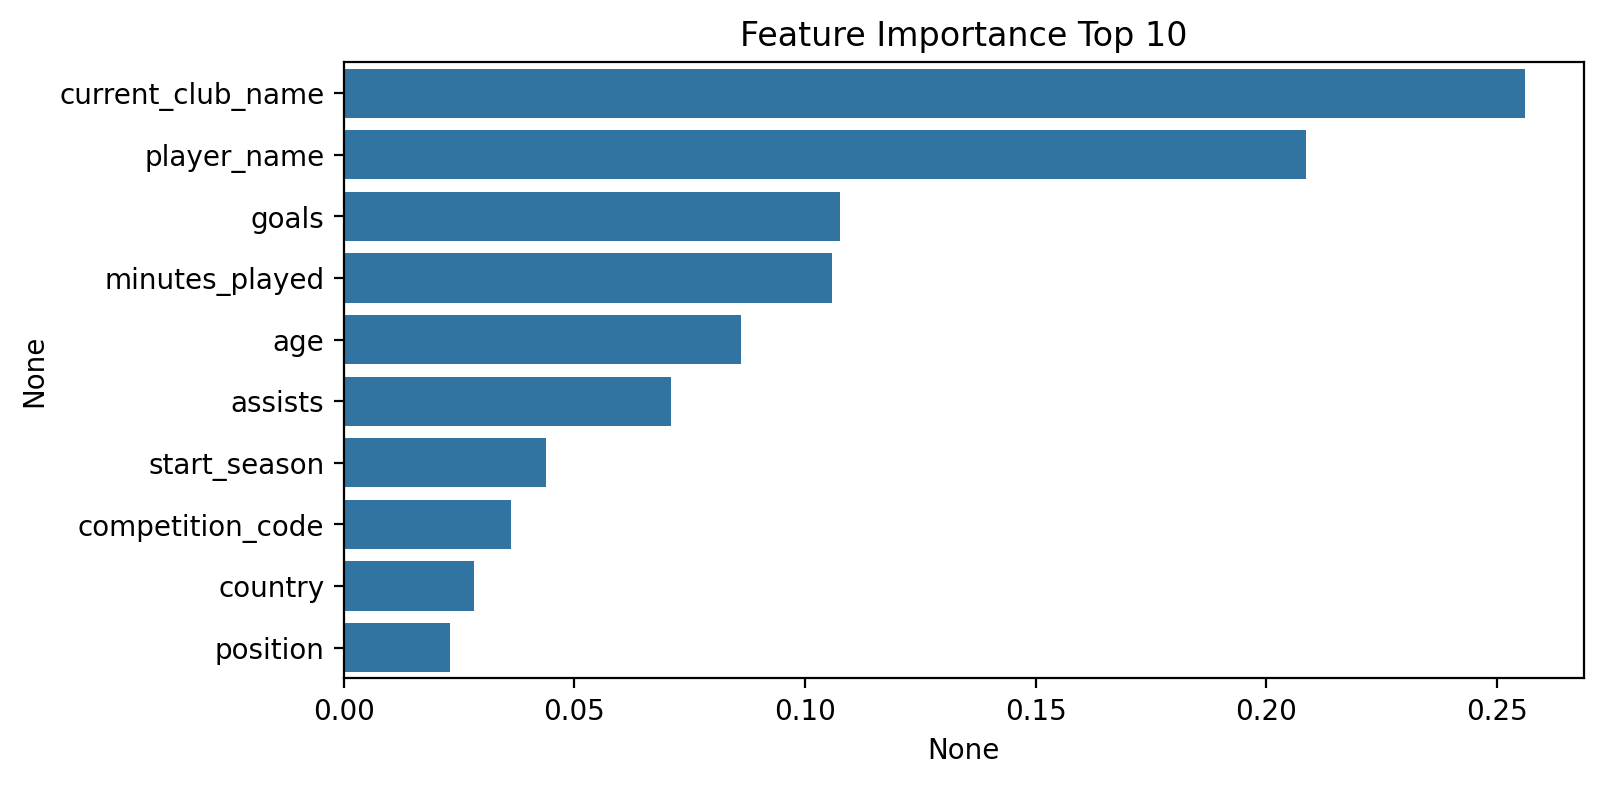

In [92]:
# feature importance 파악

# 배열형태로 반환
xgb_importance_values = model_xgb.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
xgb_series = pd.Series(xgb_importance_values, index = X_train.columns)
xgb_top10 = xgb_series.sort_values(ascending=False)[:10]

# 시각화
plt.figure(figsize=(8,4))
plt.title('Feature Importance Top 10')
sns.barplot(x=xgb_top10, y=xgb_top10.index)
plt.show()


# 이 지표는 절대적이지 않다.
# 중요도는 낮게 평가되었지만 실제로 중요한 특성일 수도 있고,
# 그렇기 때문에 제거했을 경우 성능이 떨어질 수도 있다.
# -> 상위 n개의 특성들을 제외한 나머지 특성들을 모두 제거하는 방식은 바람직하지 못함

# feature importance를 고려하여 특성별로 A/B test 를 진행하며 feature selection 해야 한다
# https://hwi-doc.tistory.com/entry/Feature-selection-feature-importance-vs-permutation-importance

In [93]:
model_xgb.score(X_train_robust, y_train)

0.9034212296215226

In [94]:
model_xgb.score(X_val_robust, y_val)

0.7673726808119388

In [95]:
model_xgb.score(X_test_robust, y_test)

0.7028692326933028

In [96]:
model_xgb.predict(X_test_robust)

array([-1641967.8, 15791167. , 14232742. , ...,  2353040.2,    52526. ,
       24503766. ], dtype=float32)

In [97]:
metrics.mean_squared_error(y_test, model_xgb.predict(X_test_robust), squared=False)

8977188.733237214

In [98]:
# 1446
# Kai Havertz
model_xgb.predict(X_test_robust)[1446]

66137976.0

In [99]:
y_test

7          900000.0
11       30000000.0
21       28000000.0
26       15000000.0
27         500000.0
            ...    
15983     5000000.0
15988     1800000.0
15994     1000000.0
15995     1000000.0
16000    18000000.0
Name: market_value_per_season, Length: 2920, dtype: float64

In [100]:
X_test

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7,3.090621e+06,2023,0,0,235,1.760686e+07,34,7.573533e+06,1.669718e+07,1.580558e+07,9.059222e+06,170.0
11,1.378455e+07,2023,0,0,720,1.760686e+07,21,6.410489e+06,1.246267e+07,1.165922e+07,8.371419e+06,185.0
21,1.869467e+07,2023,0,0,540,1.760686e+07,25,5.777534e+06,3.253681e+07,1.580558e+07,8.982164e+06,190.0
26,6.612677e+06,2023,0,0,526,1.760686e+07,21,1.040246e+07,4.469679e+06,1.580558e+07,8.982164e+06,181.0
27,8.983092e+06,2023,1,0,298,9.004052e+06,28,9.240542e+06,1.740985e+06,8.238751e+06,9.059222e+06,199.0
...,...,...,...,...,...,...,...,...,...,...,...,...
15983,4.012582e+06,2023,1,0,2093,9.404664e+06,29,9.814288e+06,3.976935e+06,7.964127e+06,8.982164e+06,177.0
15988,2.202918e+06,2023,1,4,1664,9.404664e+06,34,6.410489e+06,8.704671e+06,7.964127e+06,8.982164e+06,182.0
15994,9.018411e+05,2023,0,0,1170,9.404664e+06,33,5.777534e+06,1.168214e+07,1.263018e+07,8.982164e+06,192.0
15995,8.983092e+06,2023,1,0,366,2.712768e+06,22,1.059005e+07,9.386958e+05,6.922201e+06,9.059222e+06,170.0


In [101]:
y_test[y_test == 55000000.0]

1760     55000000.0
3380     55000000.0
7842     55000000.0
8596     55000000.0
8752     55000000.0
9670     55000000.0
10023    55000000.0
10024    55000000.0
14431    55000000.0
15091    55000000.0
Name: market_value_per_season, dtype: float64

In [102]:
y_test.reset_index()

,index,market_value_per_season
0,7,900000.0
1,11,30000000.0
2,21,28000000.0
3,26,15000000.0
4,27,500000.0
...,...,...
2915,15983,5000000.0
2916,15988,1800000.0
2917,15994,1000000.0
2918,15995,1000000.0


In [103]:
y_test.reset_index()[y_test.reset_index()["index"]==7842]

,index,market_value_per_season
1446,7842,55000000.0


In [104]:
df[df.player_name=="Kai Havertz"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,market_value_per_season,country,foot,height_in_cm
7838,Kai Havertz,2019,12,6,2463,bundesliga,20,Attacking Midfield,Arsenal Football Club,81000000.0,Germany,left,193.0
7839,Kai Havertz,2020,4,5,1520,premier-league,21,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7840,Kai Havertz,2021,8,4,1811,premier-league,22,Attacking Midfield,Arsenal Football Club,70000000.0,Germany,left,193.0
7841,Kai Havertz,2022,7,1,2579,premier-league,23,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0
7842,Kai Havertz,2023,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,55000000.0,Germany,left,193.0


In [105]:
test[features][test[features].player_name=="Kai Havertz"]

,player_name,start_season,goals,assists,minutes_played,competition_code,age,position,current_club_name,country,foot,height_in_cm
7842,Kai Havertz,2023,8,3,1783,premier-league,24,Attacking Midfield,Arsenal Football Club,Germany,left,193.0
